In [1]:
%matplotlib inline

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys

lib_path = os.path.join('../src/lib')
if not lib_path in sys.path:
    sys.path.append(lib_path)
    
lib_path = os.path.join('../src/')
if not lib_path in sys.path:
    sys.path.append(lib_path)
    
lib_path = '../../Rotated_IoU/'
if not lib_path in sys.path:
    sys.path.append(lib_path)
    
import json
import cv2
from glob import glob
import math
import numpy as np
import time
from progress.bar import Bar
import torch

import matplotlib.pyplot as plt
from PIL import Image

from external.nms import soft_nms
from fhd_opts import opts
from logger import Logger
from utils.utils import AverageMeter
from datasets.dataset_factory import dataset_factory
from detectors.detector_factory import detector_factory
from models.losses import _transpose_and_gather_feat
from models.Rotated_IoU.oriented_iou_loss import cal_diou, cal_giou, cal_iou

Using tensorboardX


In [4]:
class PrefetchDataset(torch.utils.data.Dataset):
  def __init__(self, opt, dataset, pre_process_func):
    self.images = dataset.images
    self.load_image_func = dataset.coco.loadImgs
    self.img_dir = dataset.img_dir
    self.pre_process_func = pre_process_func
    self.opt = opt
  
  def __getitem__(self, index):
    img_id = self.images[index]
    img_info = self.load_image_func(ids=[img_id])[0]
    img_path = os.path.join(self.img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    images, meta = {}, {}
    for scale in opt.test_scales:
      if opt.task == 'ddd':
        images[scale], meta[scale] = self.pre_process_func(
          image, scale, img_info['calib'])
      else:
        images[scale], meta[scale] = self.pre_process_func(image, scale)
    return img_id, {'images': images, 'image': image, 'meta': meta}

  def __len__(self):
    return len(self.images)

def prefetch_test(opt):
  os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str

  Dataset = dataset_factory[opt.dataset]
  opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
  print(opt)
  Logger(opt)
  Detector = detector_factory[opt.task]
  
  split = 'val' if not opt.trainval else 'test'
  dataset = Dataset(opt, split)
  detector = Detector(opt)
  
  data_loader = torch.utils.data.DataLoader(
    PrefetchDataset(opt, dataset, detector.pre_process), 
    batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

  results = {}
  num_iters = len(dataset)
  bar = Bar('{}'.format(opt.exp_id), max=num_iters)
  time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge']
  avg_time_stats = {t: AverageMeter() for t in time_stats}
  for ind, (img_id, pre_processed_images) in enumerate(data_loader):
    ret = detector.run(pre_processed_images)
    results[img_id.numpy().astype(np.int32)[0]] = ret['results']
    Bar.suffix = '[{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(
                   ind, num_iters, total=bar.elapsed_td, eta=bar.eta_td)
    for t in avg_time_stats:
      avg_time_stats[t].update(ret[t])
      Bar.suffix = Bar.suffix + '|{} {tm.val:.3f}s ({tm.avg:.3f}s) '.format(
        t, tm = avg_time_stats[t])
    bar.next()
  bar.finish()
  dataset.run_eval(results, opt.save_dir)

In [31]:
args = ['eldet']
opt = opts().parse(args)
# opt.data_dir = '/data/cc/Data/CHD/fake_data/'
# opt.load_model = '/data/cc/workspace/Repository/CenterNet/exp/eldet/fake_0214_eldet_fhd_dla_iouw5_nocrop_896x608/model_last.pth'
# opt.load_model = '/data/cc/workspace/Repository/CenterNet/exp/eldet/fake_0209_eldet_fhd_dla_rl_nocrop_896x608/model_best.pth'
opt.data_dir = '/data/cc/Data/CHD/detection/'
opt.load_model = '/data/cc/workspace/Repository/CenterNet/exp/eldet/exp3_base_theta5_iou/model_120.pth'
opt.num_classes = 2
opt.dataset = 'coco_fhd'
opt.resume = True
opt.gpus_str = '5'

torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test
Dataset = dataset_factory[opt.dataset]
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)

exp_name = opt.load_model.split('/')[-2]
save_pred_folder = os.path.join('../exp/prediction/', exp_name)
if not os.path.exists(save_pred_folder):
    os.makedirs(save_pred_folder)
    
print(opt)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  /data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet/default
heads {'hm': 2, 'reg': 2, 'l': 1, 'ratio_al': 1, 'ratio_bl': 1, 'theta': 1}
Namespace(K=2, aggr_weight=0.0, agnostic_ex=False, arch='dla_34', aug_ddd=0.5, aug_rot=0, batch_size=32, cat_spec_wh=False, center_thresh=0.1, chunk_sizes=[32], data_dir='/data/cc/Data/CHD/detection/', dataset='coco_fhd', debug=0, debug_dir='/data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet/default/debug', debugger_theme='white', demo='', dense_hp=False, dense_wh=False, dep_weight=1, dim_weight=1, down_ratio=4, ellipse_reg_weight=0, ellipse_weight=1, eval_oracle_dep=False, eval_oracle_hm=False, eval_oracle_hmhp=False, eval_oracle_hp_offset=False, eval_oracle_kps=False, eval_oracle_offset=False, eval_oracle_wh=False, exp_dir='/data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet', exp_id='default', fix_res=True, flip=0.5, flip_test=False, gaussi

In [32]:
Detector = detector_factory[opt.task]
split = 'val'
# split = 'train'
# opt.mean = [0, 0, 0]
# opt.std = [1, 1, 1]
print(opt.mean, opt.std)
dataset = Dataset(opt, split)
detector = Detector(opt)

model = detector.model

[[[0.216 0.216 0.216]]] [[[0.222 0.222 0.222]]]
==> initializing Fetal Heart Disease val data.
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loaded val 417 samples
Creating model...
loaded /data/cc/workspace/Repository/CenterNet/exp/eldet/exp3_base_theta5_iou/model_120.pth, epoch 120


In [209]:
ind = 0
img_id = dataset.images[ind]
img_info = dataset.coco.loadImgs(ids=[img_id])[0]
img_path = os.path.join(dataset.img_dir, img_info['file_name'])
print(img_path)

image = cv2.imread(img_path)

/data/cc/Data/CHD/detection/images/normal_0001.png


In [210]:
ret = detector.run(img_path)
ret

{'results': {1: array([[ 2.3447772e+02, -2.4718264e+01,  7.8866663e+02,  5.2947064e+02,
           5.1157217e+02,  2.5237619e+02,  5.5418890e+02,  7.9668820e-01,
           6.1238170e-01, -4.6667669e-02,  8.7642872e-01]], dtype=float32),
  2: array([[ 4.1047830e+02,  6.3528111e+01,  7.7597925e+02,  4.2902905e+02,
           5.9322882e+02,  2.4627859e+02,  3.6550098e+02,  9.9993742e-01,
           7.2418910e-01, -4.9087547e-02,  8.4101719e-01]], dtype=float32)},
 'tot': 0.04800748825073242,
 'load': 0.008001327514648438,
 'pre': 0.012001752853393555,
 'net': 0.02400374412536621,
 'dec': 0.0,
 'post': 0.004000663757324219,
 'merge': 0.0}

# With Ground Truth

In [11]:
ann = anns[class_idx]
cx_gt, cy_gt, a_gt, b_gt, theta_gt = ann['ellipse']
l_gt = 2 * math.sqrt(a_gt ** 2 + b_gt ** 2)
pt1 = (int(cx_gt - l_gt / 2), int(cy_gt - l_gt / 2))
pt2 = (int(cx_gt + l_gt / 2), int(cy_gt + l_gt / 2))
ratio_al, ratio_ba = a_gt / l_gt, b_gt / a_gt
angle_gt = theta_gt * 180
print("Ground Truth:", pt1, pt2, (cx_gt, cy_gt), l, ratio_al, ratio_ba, theta_gt, a_gt, b_gt, int(angle_gt))

NameError: name 'anns' is not defined

In [11]:
min(thetas), max(thetas)

(-0.34587318389231014, 0.4469070802020421)

In [144]:
image.shape

(360, 480, 3)

In [229]:
ell1 = [cx, cy, a, b, angle]
ell2 = [cx_gt, cy_gt, a_gt, b_gt, angle_gt]
ell1, ell2

([271, 257, 78.13416111469269, 54.25057339668274, 37.65756279230118],
 [271, 260, 41.6, 50.313, -29.025620983028098])

In [235]:
iouloss, bboxiou = compute_rotated_bbox_iou(ell1, ell2)

In [236]:
bboxiou.item()

0.488799124956131

In [223]:
compute_single_class_metric(ell1, ell2, shape)

(0.6571257002316224, 0.48934267365528195, 66.68318377532927)

In [237]:
# Calculate Metrics: Dice and difference of angles
# input 2 ellipse ell1, ell2 in [cx, cy, a, b, angle], image shape [h, w], num_classes

def compute_dice(pred, label):
    
    ints = np.sum((pred == 1) * (label == 1))
    sums = np.sum(pred == 1) + np.sum(label == 1) + 1e-5
    
    return (2.0 * ints) / sums

def compute_iou(pred, label):
    
    inter = np.sum((pred == 1) * (label == 1))
    union = np.sum((pred == 1) + (label == 1)) + 1e-5
    
    return inter / union

def compute_rotated_bbox_iou(ell1, ell2):
    cx1, cy1, a1, b1, angle1 = ell1
    cx2, cy2, a2, b2, angle2 = ell2
    theta1 = angle1 / 180.0 * math.pi
    theta2 = angle2 / 180.0 * math.pi
    bbox1 = torch.tensor([[[cx1, cy1, 2 * a1, 2 * b1, theta1]]], dtype=torch.float).cuda()
    bbox2 = torch.tensor([[[cx2, cy2, 2 * a2, 2 * b2, theta2]]], dtype=torch.float).cuda()
    return cal_diou(bbox1, bbox2) # iou_loss, iou

def compute_single_class_metric(ell1, ell2, shape):
    cx1, cy1, a1, b1, angle1 = ell1
    cx2, cy2, a2, b2, angle2 = ell2
    h, w = shape
    pred = np.zeros([h, w], np.uint8)
    pred = cv2.ellipse(pred, (cx1, cy1), (int(a1), int(b1)), int(angle1), 0.0, 360.0, (1), thickness=-1)
    label = np.zeros([h, w], np.uint8)
    label = cv2.ellipse(label, (cx2, cy2), (int(a2), int(b2)), int(angle2), 0.0, 360.0, (1), thickness=-1)
    angle_error = abs(angle1 - angle2)
    angle_error = angle_error if angle_error <= 90 else (180 - angle_error)
    bbox_iou_loss, bbox_iou = compute_rotated_bbox_iou(ell1, ell2)
    return compute_dice(pred, label), compute_iou(pred, label), bbox_iou.item(), angle_error

### Using Ratio_ba

In [166]:
angle_errors = []
dices = []

for ind in range(len(dataset)):
    cls_dice = []
    cls_angle_error = []
    
    # Load Image
    img_id = dataset.images[ind]
    img_info = dataset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(dataset.img_dir, img_info['file_name'])
    image = cv2.imread(img_path)

    # Load annotations
    ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
    anns = dataset.coco.loadAnns(ids=ann_ids)

    # Inference
    color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]
    ret = detector.run(img_path)

    for class_idx in range(opt.num_classes):
        class_id = class_idx + 1
        pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
        pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
        cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
        l = int(ret['results'][class_id][0, 6]) # !attention here!
        ratio_al = ret['results'][class_id][0, 7]
        ratio_ba = ret['results'][class_id][0, 8]
        a = ratio_al * l / 2
        b = ratio_ba * a
        theta = ret['results'][class_id][0, 9]
        angle = theta * 180
        print("Predict:     ", pt1, pt2, (cx, cy), l, ratio_al, ratio_ba, "({})'".format(theta), int(a), int(b), int(angle))

        # Annotations
        ann = anns[class_idx]
        cx_gt, cy_gt, a_gt, b_gt, theta_gt = ann['ellipse']
        theta_gt = theta_gt / math.pi
        theta_gt = theta_gt - 1 if theta_gt > 0.5 else theta_gt + 1 if theta_gt < -0.5 else theta_gt
        l_gt = 2 * math.sqrt(a_gt ** 2 + b_gt ** 2)
        pt1 = (int(cx_gt - l_gt / 2), int(cy_gt - l_gt / 2))
        pt2 = (int(cx_gt + l_gt / 2), int(cy_gt + l_gt / 2))
        ratio_al, ratio_ba = 2 * a_gt / l_gt, b_gt / a_gt
        angle_gt = theta_gt * 180
        print("Ground Truth:", pt1, pt2, (cx_gt, cy_gt), l_gt, ratio_al, ratio_ba, "({})'".format(theta_gt), int(a_gt), int(b_gt), int(angle_gt))
        img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=(125, 0, 0), thickness=1)
        img = cv2.ellipse(img, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, (255, 0, 0), thickness=2)
    #     img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2 + 1], thickness=2)
    #     img = cv2.ellipse(image, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=2)


        pt1 = (int(cx - l / 2), int(cy - l / 2))
        pt2 = (int(cx + l / 2), int(cy + l / 2))
        img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
        img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)
        
        pred_ell = [cx, cy, a, b, angle]
        gt_ell = [cx_gt, cy_gt, a_gt, b_gt, angle_gt]
        error = compute_single_class_metric(pred_ell, gt_ell, shape)
        print("dice: {}  iou:{}  angle_error: {}".format(error[0], error[1], error[2]))
        cls_dice.append(error[0])
        cls_angle_error.append(error[1])

#     img = Image.fromarray(image)
#     img.save(os.path.join(save_pred_folder, img_path.split('/')[-1]))
#     print("Saving", img_path, "to", os.path.join(save_pred_folder, img_path.split('/')[-1]))
    dices.append(cls_dice)
    angle_errors.append(cls_angle_error)
#     img


Predict:      (241, -17) (795, 537) (518, 260) 554 0.7576092 0.6157862 (-0.027996793389320374)' 209 129 -5
Ground Truth: (234, -1) (767, 531) (501, 265) 532.9805225859571 0.8107538299963108 0.7220283442408983 (-0.007509774878940667)' 216 156 -1
dice: 0.8765245733348381   angle_error: 3.687663331868347
Predict:      (444, 102) (730, 389) (587, 245) 286 0.84249675 0.5613137 (0.012172100134193897)' 120 67 2
Ground Truth: (450, 106) (727, 383) (589, 245) 277.34379191898273 0.8457157031606375 0.630984762570666 (-0.06289569507492021)' 117 74 -11
dice: 0.910613892595062   angle_error: 13.51220313764054
Predict:      (-4, -1) (729, 732) (362, 365) 733 0.7949063 0.6210448 (0.08276823163032532)' 291 180 14
Ground Truth: (-18, 4) (712, 735) (347, 370) 730.7699743038161 0.8144669607793051 0.71237995389692 (0.07671268257029355)' 297 212 13
dice: 0.9038783792831016   angle_error: 1.0899988308057171
Predict:      (60, 198) (433, 571) (247, 384) 372 0.9724063 0.54538834 (-0.017669295892119408)' 180 98

Predict:      (27, -94) (992, 870) (510, 388) 965 0.49774075 0.484161 (-0.0653826892375946)' 240 116 -11
Ground Truth: (-14, -103) (988, 899) (487, 398) 1003.0058268245504 0.6580220995221095 1.1443363636363635 (0.21600275032932348)' 330 377 38
dice: 0.3909317838709757   angle_error: 50.649379122045254
Predict:      (225, 227) (741, 743) (483, 485) 516 0.84995645 0.8333367 (0.11114288866519928)' 219 182 20
Ground Truth: (230, 210) (773, 753) (502, 482) 542.3388374402114 0.6503056311892487 1.1681779259738125 (0.019735212943395024)' 176 206 3
dice: 0.8908412980567878   angle_error: 16.453381629924767
Predict:      (-24, -104) (788, 709) (381, 302) 813 0.62229455 0.5169543 (0.15807215869426727)' 252 130 28
Ground Truth: (-30, -102) (782, 710) (376, 304) 813.3605769866155 0.754295225707867 0.8703957855892449 (0.09899437460315891)' 306 267 17
dice: 0.5733337771257494   angle_error: 10.634001136399505
Predict:      (77, 54) (499, 475) (288, 264) 421 0.9376192 0.604052 (0.20685812830924988)' 1

dice: 0.8184322372766413   angle_error: 45.89891067403198
Predict:      (118, 39) (936, 857) (527, 448) 817 0.42182234 0.47076538 (-0.2060617357492447)' 172 81 -37
Ground Truth: (116, 19) (967, 870) (542, 445) 850.3828747099744 0.6538231384182395 1.1572661870503598 (-0.28634923517594124)' 278 321 -51
dice: 0.2902857744026132   angle_error: 14.451749896805381
Predict:      (266, 152) (665, 551) (466, 351) 399 0.9623983 0.98971623 (-0.06169808283448219)' 191 190 -11
Ground Truth: (286, 184) (655, 553) (471, 369) 369.6803542305163 0.6383893471732632 1.2057118644067797 (-0.042653524748627956)' 118 142 -7
dice: 0.6330870803417828   angle_error: 3.4280204554537628
Predict:      (153, -20) (895, 721) (524, 350) 742 0.39079162 0.43447298 (-0.21318461000919342)' 144 62 -38
Ground Truth: (136, -23) (897, 737) (517, 357) 760.0028847971566 0.6657869464996182 1.1206916996047431 (-0.22790987850759412)' 253 283 -41
dice: 0.22324042154148566   angle_error: 2.650548329712123
Predict:      (278, 37) (69

Predict:      (245, -67) (1019, 705) (632, 319) 773 0.72886413 0.614695 (-0.11990858614444733)' 281 173 -21
Ground Truth: (171, -104) (1034, 758) (603, 327) 862.9805904862519 0.8470642423001813 0.6274500683994528 (-0.021515409871027513)' 365 229 -3
dice: 0.7361196165981955   angle_error: 17.710771729215566
Predict:      (341, 161) (760, 580) (551, 370) 419 0.97236955 0.67247427 (-0.22751548886299133)' 203 136 -40
Ground Truth: (344, 153) (765, 574) (555, 364) 421.0188129288286 0.7439620045029883 0.8981936134754265 (-0.3116253785739311)' 156 140 -56
dice: 0.8704570933809247   angle_error: 15.139780147969155
Predict:      (137, 32) (725, 620) (431, 326) 588 0.6892016 0.6887778 (-0.06111012026667595)' 202 139 -10
Ground Truth: (137, 36) (728, 627) (433, 332) 591.4006742573093 0.6515616514707373 1.1642730721919166 (0.15775204115768993)' 192 224 28
dice: 0.7889534909311645   angle_error: 39.39518905638586
Predict:      (232, 232) (560, 561) (396, 397) 328 0.7330477 0.82583237 (0.09679332375

Predict:      (166, 24) (995, 854) (580, 439) 829 0.7710082 0.6334691 (0.13473822176456451)' 319 202 24
Ground Truth: (131, 15) (956, 840) (544, 428) 825.8888538732073 0.7859241554792183 0.7867462863164512 (0.11000555823012126)' 324 255 19
dice: 0.8585760510550868   angle_error: 4.4518794361997855
Predict:      (453, 277) (885, 709) (669, 493) 431 0.87529767 0.62623376 (0.13429009914398193)' 188 118 24
Ground Truth: (450, 290) (857, 697) (654, 494) 406.9754337254277 0.7797374821746472 0.8029710021617602 (0.264067543143076)' 158 127 47
dice: 0.8767065804789137   angle_error: 23.359939919836933
Predict:      (252, 28) (894, 669) (573, 348) 641 0.7528335 0.6247765 (-0.08829770237207413)' 241 150 -15
Ground Truth: (202, 24) (869, 691) (536, 358) 666.7369132273989 0.795915134548745 0.7606441716635323 (-0.07225634416372048)' 265 201 -13
dice: 0.7978813979935759   angle_error: 2.8874444775036565
Predict:      (330, 255) (653, 578) (491, 416) 322 0.78597474 0.6888177 (-0.1726381927728653)' 126

Predict:      (139, -26) (736, 571) (438, 272) 597 0.7877608 0.61647624 (0.03419020026922226)' 235 144 6
Ground Truth: (124, -54) (777, 598) (451, 272) 653.7873635487306 0.79099723982575 0.7734789536376715 (0.038515496228238674)' 258 200 6
dice: 0.7926059579734842   angle_error: 0.7785532726229549
Predict:      (337, 81) (690, 434) (514, 258) 353 0.99419373 0.59684664 (-0.06976382434368134)' 175 104 -12
Ground Truth: (361, 100) (692, 431) (527, 266) 330.9626089454819 0.8137898140764483 0.7141393214373232 (-0.04201690497626037)' 134 96 -7
dice: 0.8209671013612562   angle_error: 4.994445486135773
Predict:      (225, 56) (802, 632) (514, 344) 576 0.7716233 0.6295449 (-0.09026967734098434)' 222 139 -16
Ground Truth: (206, 55) (769, 618) (488, 337) 562.1437632848025 0.7815829840976164 0.7981254637406057 (-0.0681183156433312)' 219 175 -12
dice: 0.8581074580800596   angle_error: 3.987245105577564
Predict:      (278, 198) (599, 520) (438, 359) 321 0.8872549 0.5917217 (0.07646262645721436)' 142

Ground Truth: (344, 201) (721, 578) (533, 390) 377.3381024439488 0.7968079503570993 0.7583165372872224 (0.021326762374313978)' 150 114 3
dice: 0.8471653474563845   angle_error: 2.2602799798120903
Predict:      (170, 54) (775, 659) (472, 357) 605 0.77633494 0.6311067 (0.1082756370306015)' 234 148 19
Ground Truth: (113, 48) (776, 711) (445, 380) 663.521025442299 0.6299725012050128 1.2327799043062202 (-0.34587318389231014)' 209 257 -62
dice: 0.7799613563765537   angle_error: 81.7467877661241
Predict:      (378, 234) (685, 542) (532, 388) 307 0.826829 0.629186 (0.17228709161281586)' 126 79 31
Ground Truth: (366, 230) (719, 583) (543, 407) 352.8624832707495 0.5327854586789511 1.5883510638297873 (-0.2166393701016912)' 94 149 -38
dice: 0.8172422883183176   angle_error: 70.00676310861127
Predict:      (113, 62) (631, 579) (372, 321) 517 0.62699497 0.6697818 (0.1874539703130722)' 162 108 33
Ground Truth: (115, 28) (698, 611) (407, 320) 582.5181212631929 0.7861729674725172 0.7860948554458905 (-0

dice: 0.8690518581564695   angle_error: 12.335877492027814
Predict:      (42, -28) (530, 459) (286, 215) 487 0.7679552 0.6171242 (0.0188760906457901)' 186 115 3
Ground Truth: (45, -27) (536, 463) (291, 218) 490.1780194541571 0.769585711778902 0.8297237258571604 (-0.034566115204562875)' 188 156 -6
dice: 0.8406441420384111   angle_error: 9.619597053063536
Predict:      (70, 85) (368, 383) (219, 234) 297 0.9999355 0.6643646 (-0.11673911660909653)' 148 98 -21
Ground Truth: (97, 102) (354, 359) (226, 231) 256.7882067073953 0.8172026382781563 0.7052723876329533 (-0.12445916549786216)' 104 74 -22
dice: 0.6947110939467396   angle_error: 1.3896087999778146
Predict:      (49, 88) (652, 690) (350, 389) 602 0.4860138 0.5615319 (0.12746863067150116)' 146 82 22
Ground Truth: (80, 56) (683, 659) (382, 358) 603.783182054618 0.6845735560130424 1.0648144115896587 (-0.0789408517735801)' 206 220 -14
dice: 0.4197644246762215   angle_error: 37.15370684011462
Predict:      (191, 117) (570, 496) (381, 306) 37

Predict:      (-11, -97) (739, 654) (363, 278) 751 0.7546286 0.6754448 (-0.047953180968761444)' 283 191 -8
Ground Truth: (-10, -103) (738, 645) (364, 271) 748.0140752927045 0.6122879436737612 1.2912794759825326 (0.3717859470626675)' 229 295 66
dice: 0.8888395863226638   angle_error: 75.5530430456572
Predict:      (237, -2) (632, 392) (434, 195) 395 0.65702856 0.8414592 (0.17099355161190033)' 129 109 30
Ground Truth: (221, -3) (636, 411) (429, 204) 415.16698443397445 0.8125453435559704 0.7173728738194474 (-0.36178867820149974)' 168 121 -65
dice: 0.7984760080986475   angle_error: 84.09919863358799
Predict:      (21, -58) (791, 711) (406, 326) 769 0.77872795 0.6191743 (0.06608293205499649)' 299 185 11
Ground Truth: (10, -61) (791, 719) (401, 329) 780.8437502496898 0.778644895096593 0.8058421052631579 (0.08135766847358006)' 304 244 14
dice: 0.8545991736847429   angle_error: 2.7494525553450426
Predict:      (81, 124) (471, 514) (276, 319) 389 0.997698 0.57608443 (-0.031273920089006424)' 194

Predict:      (38, -96) (943, 808) (491, 355) 905 0.7481788 0.6195896 (-0.11788546293973923)' 338 209 -21
Ground Truth: (22, -116) (959, 820) (491, 352) 937.9340217392693 0.8209532676639038 0.6955272727272728 (-0.0818056407492342)' 385 267 -14
dice: 0.815082230229756   angle_error: 6.494367994290904
Predict:      (199, 250) (618, 669) (408, 459) 418 0.9898829 0.6438921 (-0.2502283453941345)' 206 133 -45
Ground Truth: (200, 243) (629, 672) (415, 458) 429.52494786217017 0.7995018722642281 0.7512972982417313 (-0.2762929812075303)' 171 129 -49
dice: 0.8917075045071133   angle_error: 4.691634446411243
Predict:      (105, -24) (837, 707) (471, 341) 731 0.73528415 0.6306553 (-0.06508935242891312)' 268 169 -11
Ground Truth: (96, -64) (913, 752) (505, 344) 816.2860709555198 0.8106153265918662 0.7223882942870874 (-0.07384789359463945)' 330 239 -13
dice: 0.729835544046372   angle_error: 1.57653740983074
Predict:      (293, 67) (662, 435) (478, 251) 368 0.68604225 0.7921167 (-0.03183385729789734)'

Predict:      (81, -1) (705, 623) (393, 311) 624 0.7412055 0.64138925 (-0.1871720254421234)' 231 148 -33
Ground Truth: (80, -45) (737, 611) (409, 283) 656.0760493601333 0.7712520530104681 0.8253201581027668 (-0.111915417547224)' 253 208 -20
dice: 0.7773939931950468   angle_error: 13.546189421081895
Predict:      (170, 193) (510, 533) (340, 363) 339 0.82134044 0.71966463 (-0.13840611279010773)' 139 100 -24
Ground Truth: (196, 202) (499, 505) (348, 354) 302.23204658672444 0.688212922319325 1.0541923076923077 (0.08231259813213143)' 104 109 14
dice: 0.8634275197036159   angle_error: 39.729367966003046
Predict:      (125, -53) (960, 780) (542, 363) 834 0.48402765 0.5047707 (0.14186812937259674)' 201 101 25
Ground Truth: (62, -140) (973, 770) (518, 315) 911.4671882388307 0.6538907902451347 1.1570570469798658 (-0.3516027618436184)' 298 344 -63
dice: 0.33191920601193037   angle_error: 88.82476041891871
Predict:      (398, 270) (762, 634) (580, 452) 363 0.98463607 0.66105396 (-0.037303477525711

Predict:      (29, -44) (831, 757) (430, 356) 802 0.71400505 0.71550995 (0.15458375215530396)' 286 204 27
Ground Truth: (65, -31) (810, 713) (438, 341) 744.3436572578556 0.784583833429094 0.7902568493150685 (-0.18703655068659863)' 292 230 -33
dice: 0.833001062570637   angle_error: 61.491654511542464
Predict:      (274, 10) (770, 507) (522, 258) 496 0.9958864 0.9990631 (0.08486433327198029)' 246 246 15
Ground Truth: (317, 56) (716, 455) (517, 256) 398.7275441501377 0.6019147749412312 1.3267 (0.1200028270912891)' 120 159 21
dice: 0.48069795060776954   angle_error: 6.324928887475586
Predict:      (115, 13) (610, 508) (363, 261) 494 0.72426414 0.6428121 (-0.04697362706065178)' 178 114 -8
Ground Truth: (97, -3) (630, 529) (364, 263) 532.1639248351959 0.7932969152892854 0.7674742517126046 (-0.11841127766037013)' 211 162 -21
dice: 0.7454840567135287   angle_error: 12.858777107949305
Predict:      (186, 159) (465, 438) (325, 298) 278 0.6924649 0.7680466 (0.0629831850528717)' 96 73 11
Ground Tr

Predict:      (301, 84) (772, 554) (536, 319) 470 0.73394203 0.6297684 (-0.010034121572971344)' 172 108 -1
Ground Truth: (313, 87) (762, 536) (538, 312) 448.2247861642638 0.7855968943916344 0.7876032306801013 (-0.00846470453749193)' 176 138 -1
dice: 0.8671200607823546   angle_error: 0.2824950663862946
Predict:      (469, 198) (727, 455) (598, 326) 257 0.814625 0.6131984 (0.13099758327007294)' 104 64 23
Ground Truth: (476, 204) (711, 439) (594, 322) 234.71995243694133 0.8190441332491657 0.7004879165236207 (0.05557456769269298)' 96 67 10
dice: 0.9212818166479136   angle_error: 13.576142803928393
Predict:      (257, 170) (902, 816) (579, 493) 645 0.72200054 0.6109365 (0.11258967965841293)' 232 142 20
Ground Truth: (242, 150) (925, 833) (584, 492) 682.935303770423 0.8492751755515835 0.6216482758620689 (0.09695485289658579)' 290 180 17
dice: 0.7828943402754921   angle_error: 2.8142688171288874
Predict:      (294, 286) (674, 666) (484, 476) 380 0.9466833 0.58466846 (0.037342607975006104)' 17

Predict:      (96, 19) (716, 639) (406, 329) 620 0.43146366 0.4784568 (0.08389246463775635)' 133 63 15
Ground Truth: (103, 35) (724, 656) (414, 346) 621.9173736277191 0.6753437318369844 1.092041103978972 (0.12764226435970008)' 210 229 22
dice: 0.2985826948276174   angle_error: 7.874963949949873
Predict:      (211, 77) (576, 442) (394, 260) 364 0.9945873 0.97644675 (-0.08249195665121078)' 181 176 -14
Ground Truth: (222, 91) (565, 434) (394, 263) 342.25661957075425 0.6505820114721508 1.1673178662211565 (-0.06416893461965545)' 111 129 -11
dice: 0.6214047648012314   angle_error: 3.2981439656799605
Predict:      (83, 1) (409, 327) (246, 164) 325 0.39294636 0.40949443 (-0.20965707302093506)' 63 26 -37
Ground Truth: (90, 12) (405, 327) (248, 170) 315.8620167161604 0.6534498897519386 1.1584205426356589 (-0.197670439320134)' 103 119 -35
dice: 0.2397166983928728   angle_error: 2.157594066144192
Predict:      (132, 33) (319, 220) (225, 127) 186 0.79412687 0.9152461 (-0.011139829643070698)' 73 67 

Predict:      (325, -86) (1032, 620) (678, 267) 706 0.72332495 0.60138106 (-0.08314834535121918)' 255 153 -14
Ground Truth: (331, -168) (1156, 656) (744, 244) 824.2741047103203 0.7912853215608651 0.7727264364432506 (-0.3445999443475749)' 326 252 -62
dice: 0.6534217945477558   angle_error: 47.06128781934403
Predict:      (432, 155) (791, 514) (612, 335) 359 0.8968124 0.6537366 (-0.28369584679603577)' 160 105 -51
Ground Truth: (436, 142) (815, 521) (626, 332) 378.76674160226895 0.8102295325661233 0.7233909439274263 (-0.25146481008519467)' 153 111 -45
dice: 0.9266110007744588   angle_error: 5.8015866079514
Predict:      (102, 32) (705, 636) (403, 334) 603 0.7748725 0.6229523 (-0.004492631647735834)' 233 145 0
Ground Truth: (118, 67) (693, 642) (406, 355) 575.5595909686502 0.7448994104649581 0.8956602462132698 (-0.15947325297807913)' 214 192 -28
dice: 0.8441508394908149   angle_error: 27.896511839461795
Predict:      (305, 160) (639, 494) (472, 327) 334 0.9199774 0.5731749 (0.0376126840710

Predict:      (221, -20) (964, 721) (592, 350) 742 0.772271 0.62507904 (-0.12141142040491104)' 286 179 -21
Ground Truth: (215, 4) (932, 721) (574, 363) 716.2206644603323 0.7893293618189242 0.7778375261349928 (-0.08899710574199104)' 282 219 -16
dice: 0.880990318793829   angle_error: 5.834576639325601
Predict:      (314, 200) (721, 607) (517, 404) 406 0.920505 0.62082946 (-0.237966388463974)' 186 116 -42
Ground Truth: (306, 210) (717, 621) (512, 416) 411.9083123657497 0.8295875313547415 0.6730774858507407 (-0.21294931385695598)' 170 115 -38
dice: 0.9388179478952251   angle_error: 4.503073429263246
Predict:      (123, -14) (1002, 864) (563, 425) 879 0.6776886 0.7086948 (0.18395772576332092)' 297 211 33
Ground Truth: (152, -20) (995, 822) (574, 401) 842.9680685791128 0.6723410068845439 1.1009912450023114 (0.08658028904199107)' 283 312 15
dice: 0.8335643389983315   angle_error: 17.527938609839374
Predict:      (283, 13) (861, 590) (572, 301) 577 0.9993462 0.9274453 (-0.062005266547203064)' 

In [168]:
print(len(dices), len(angle_errors))
print(np.mean(dices, axis=0), np.mean(angle_errors))

232 232
[0.75267374 0.79902569] 20.781101087723894


### Using Ratio_bl

In [238]:
# Using ratio_bl

angle_errors = []
dices = []
ious = []
bbox_ious = []


for ind in range(len(dataset)):
    # Load Image
    
    cls_dice = []
    cls_angle_error = []
    cls_iou = []
    cls_bbox_iou = []
    
    img_id = dataset.images[ind]
    img_info = dataset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(dataset.img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    shape = image.shape[:2]

    # Load annotations
    ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
    anns = dataset.coco.loadAnns(ids=ann_ids)

    # Inference
    color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]
    ret = detector.run(img_path)

    for class_idx in range(opt.num_classes):
        try:
            class_id = class_idx + 1
            pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
            pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
            cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
            l = int(ret['results'][class_id][0, 6]) # !attention here!
            ratio_al = ret['results'][class_id][0, 7]
            ratio_bl = ret['results'][class_id][0, 8]
            a = ratio_al * l / 2
            b = ratio_bl * l / 2
            theta = ret['results'][class_id][0, 9]
            angle = theta * 180
            print("Predict:     ", pt1, pt2, (cx, cy), l, ratio_al, ratio_bl, "({})'".format(theta), int(a), int(b), int(angle))

            # Annotations
            ann = anns[class_idx]
            cx_gt, cy_gt, a_gt, b_gt, theta_gt = ann['ellipse']
            theta_gt = theta_gt / math.pi
            theta_gt = theta_gt - 1 if theta_gt > 0.5 else theta_gt + 1 if theta_gt < -0.5 else theta_gt
            l_gt = 2 * math.sqrt(a_gt ** 2 + b_gt ** 2)
            pt1 = (int(cx_gt - l_gt / 2), int(cy_gt - l_gt / 2))
            pt2 = (int(cx_gt + l_gt / 2), int(cy_gt + l_gt / 2))
            ratio_al, ratio_bl = 2 * a_gt / l_gt, 2 * b_gt / l_gt
            angle_gt = theta_gt * 180
            print("Ground Truth:", pt1, pt2, (cx_gt, cy_gt), l_gt, ratio_al, ratio_bl, "({})'".format(theta_gt), int(a_gt), int(b_gt), int(angle_gt))
            img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=(125, 0, 0), thickness=1)
            img = cv2.ellipse(img, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, (255, 0, 0), thickness=2)
        #     img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2 + 1], thickness=2)
        #     img = cv2.ellipse(image, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=2)


            pt1 = (int(cx - l / 2), int(cy - l / 2))
            pt2 = (int(cx + l / 2), int(cy + l / 2))
            img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
            img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)

            pred_ell = [cx, cy, a, b, angle]
            gt_ell = [cx_gt, cy_gt, a_gt, b_gt, angle_gt]
            error = compute_single_class_metric(pred_ell, gt_ell, shape)
            print("dice: {}  iou:{}  bbox_iou: {}  angle_error: {}".format(error[0], error[1], error[2], error[3]))
            cls_dice.append(error[0])
            cls_iou.append(error[1])
            cls_bbox_iou.append(error[2])
            cls_angle_error.append(error[3])
            
        except Exception as e:
            print(e)
            cls_dice.append(0)
            cls_iou.append(0)
            cls_bbox_iou.append(0)
            cls_angle_error.append(90)
            pass
#     img = Image.fromarray(image)
#     img.save(os.path.join(save_pred_folder, img_path.split('/')[-1]))
#     print("Saving", img_path, "to", os.path.join(save_pred_folder, img_path.split('/')[-1]))
    dices.append(cls_dice)
    ious.append(cls_iou)
    bbox_ious.append(cls_bbox_iou)
    angle_errors.append(cls_angle_error)
#     img
    break


Predict:      (234, -24) (788, 529) (511, 252) 554 0.7966882 0.6123817 (-0.0466676689684391)' 220 169 -8
Ground Truth: (234, -1) (767, 531) (501, 265) 532.9805225859571 0.8107538299963108 0.5853872454592031 (-0.007509774878940667)' 216 156 -1
dice: 0.9410012478278118  iou:0.8885763518584481  bbox_iou: 0.842580258846283  angle_error: 7.048420936109718
Predict:      (410, 63) (775, 429) (593, 246) 365 0.9999374 0.7241891 (-0.04908754676580429)' 182 132 -8
Ground Truth: (450, 106) (727, 383) (589, 245) 277.34379191898273 0.8457157031606375 0.5336337221610987 (-0.06289569507492021)' 117 74 -11
dice: 0.5318275948313469  iou:0.36223783593743153  bbox_iou: 0.3598273992538452  angle_error: 2.4854666956408664


In [240]:
print("Evaluation Done!")
print("Mean Dice: ", np.mean(dices, axis=0))
print("Mean IoU: ", np.mean(ious, axis=0))
print("Mean BBox IoU: ", np.mean(bbox_ious, axis=0))
print("Mean Angle_err: ", np.mean(angle_errors, axis=0))

Evaluation Done!
Mean Dice:  [0.94100125 0.53182759]
Mean IoU:  [0.88857635 0.36223784]
Mean BBox IoU:  [0.84258026 0.3598274 ]
Mean Angle_err:  [7.04842094 2.4854667 ]


In [196]:
np.mean(angle_errors)

TypeError: unsupported operand type(s) for /: 'list' and 'int'

# For paper visualization

In [34]:
filelist = [
    'normal_0032.png',
    'normal_0033.png',
    'normal_0100.png',
    'normal_0124.png',
    'normal_0661.png'
]

save_pred_folder = './ablation/'


save_image = True
with_gt = False
with_box = False
angle_errors = []
dices = []
ious = []
bbox_ious = []
ratios_pred = []
ratios_gt = []
ctr_precisions = []

for ind in range(len(dataset)):
    # Load Image

    cls_dice = []
    cls_angle_error = []
    cls_iou = []
    cls_bbox_iou = []
    diameter_gt = [1, 1]
    diameter_pred = [1, 1]

    img_id = dataset.images[ind]
    img_info = dataset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(dataset.img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    shape = image.shape[:2]
    
    if img_info['file_name'] not in filelist:
        continue

    # Load annotations
    ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
    anns = dataset.coco.loadAnns(ids=ann_ids)

    # Inference
    color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]
    ret = detector.run(img_path)

    for class_idx in range(opt.num_classes):
        try:
            class_id = class_idx + 1
            pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
            pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
            cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
            l = int(ret['results'][class_id][0, 6]) # !attention here!
            ratio_al = ret['results'][class_id][0, 7]
            ratio_bl = ret['results'][class_id][0, 8]
            a = ratio_al * l / 2
            b = ratio_bl * l / 2
            theta = ret['results'][class_id][0, 9]
            angle = theta * 180
            print("Predict:     ", pt1, pt2, (cx, cy), l, ratio_al, ratio_bl, "({})'".format(theta), int(a), int(b), int(angle))

            # Annotations
            ann = anns[class_idx]
            cx_gt, cy_gt, a_gt, b_gt, theta_gt = ann['ellipse']
            theta_gt = theta_gt / math.pi
            theta_gt = theta_gt - 1 if theta_gt > 0.5 else theta_gt + 1 if theta_gt < -0.5 else theta_gt
            l_gt = 2 * math.sqrt(a_gt ** 2 + b_gt ** 2)
            pt1 = (int(cx_gt - l_gt / 2), int(cy_gt - l_gt / 2))
            pt2 = (int(cx_gt + l_gt / 2), int(cy_gt + l_gt / 2))
            ratio_al, ratio_bl = 2 * a_gt / l_gt, 2 * b_gt / l_gt
            angle_gt = theta_gt * 180
            print("Ground Truth:", pt1, pt2, (cx_gt, cy_gt), l_gt, ratio_al, ratio_bl, "({})'".format(theta_gt), int(a_gt), int(b_gt), int(angle_gt))
            if with_gt and with_box:
                img = cv2.rectangle(image, pt1=pt1, pt2=pt2, color=(125, 0, 0), thickness=1)
            if with_gt:
                img = cv2.ellipse(image, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, (255, 0, 0), thickness=2)
        #     img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2 + 1], thickness=2)
        #     img = cv2.ellipse(image, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=2)


            pt1 = (int(cx - l / 2), int(cy - l / 2))
            pt2 = (int(cx + l / 2), int(cy + l / 2))
            if with_box:
                img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
            img = cv2.ellipse(image, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)

            pred_ell = [cx, cy, a, b, angle]
            gt_ell = [cx_gt, cy_gt, a_gt, b_gt, angle_gt]
            error = compute_single_class_metric(pred_ell, gt_ell, shape)
            print("dice: {}  iou:{}  bbox_iou: {}  angle_error: {}".format(error[0], error[1], error[2], error[3]))
            diameter_pred[class_idx] = b
            diameter_gt[class_idx] = b_gt
            cls_dice.append(error[0])
            cls_iou.append(error[1])
            cls_bbox_iou.append(error[2])
            cls_angle_error.append(error[3])

        except Exception as e:
            print(e)
            cls_dice.append(0)
            cls_iou.append(0)
            cls_bbox_iou.append(0)
            cls_angle_error.append(90)
            pass

    if save_image:
        img = Image.fromarray(image)
        img.save(os.path.join(save_pred_folder, img_path.split('/')[-1]))
        print("Saving", img_path, "to", os.path.join(save_pred_folder, img_path.split('/')[-1]))
    dices.append(cls_dice)
    ious.append(cls_iou)
    bbox_ious.append(cls_bbox_iou)
    angle_errors.append(cls_angle_error)
    try:
        ratio_p, ratio_g = float(diameter_pred[1]) / diameter_pred[0], float(diameter_gt[1]) / diameter_gt[0]
        ctr_precision = 1 - abs(ratio_p - ratio_g) / ratio_g
    except Exception as e:
        ctr_precision = 0
        ratio_p = 0
    print("predicted ratio: {}, truth ratio: {}, error: {}, precision: {}".format(ratio_p, ratio_g, abs(ratio_p - ratio_g), ctr_precision))
    ratios_pred.append(ratio_p)
    ratios_gt.append(ratio_g)
    ctr_precisions.append(ctr_precision)
    # break

Predict:      (90, -63) (760, 606) (425, 271) 670 0.80187404 0.6107166 (0.037225645035505295)' 268 204 6
Ground Truth: (96, -63) (765, 605) (431, 271) 669.1665837562423 0.7926217669488523 0.6097136496412714 (0.056847807237428216)' 265 204 10
name 'compute_single_class_metric' is not defined
Predict:      (348, 93) (691, 435) (519, 264) 342 0.79769695 0.5889566 (-0.12156718969345093)' 136 100 -21
Ground Truth: (363, 105) (680, 422) (522, 264) 317.64191320416137 0.8060397238428602 0.5918614395171609 (-0.1609351400195277)' 128 94 -28
name 'compute_single_class_metric' is not defined
Saving /data/cc/Data/CHD/detection/images/normal_0032.png to ./ablation/normal_0032.png
predicted ratio: 1.0, truth ratio: 1.0, error: 0.0, precision: 1.0
Predict:      (146, -75) (816, 594) (481, 259) 670 0.79927397 0.6150806 (0.05309740826487541)' 267 206 9
Ground Truth: (162, -60) (795, 572) (479, 256) 632.974693509938 0.7750199258041868 0.6319367963700745 (0.052202821334141676)' 245 200 9
name 'compute_sin

In [158]:
dices

[[0.9299634954160939, 0.9256375281124264],
 [0.9502288272981095, 0.8538003680097701],
 [0.9471889848351555, 0.6420789677409052],
 [0.961675231863847, 0.9315834357690742],
 [0.9475476682824306, 0.769730984948765],
 [0.9648238350849353, 0.9410642464316117],
 [0.8518621754097466, 0.8946814111849581],
 [0.9496191714216228, 0.9180043254935477],
 [0.8899719249824246, 0.8305327671916716],
 [0.9059321713200899, 0.8053884054088072],
 [0.7277319888349941, 0.5032505691371301],
 [0.878973909948452, 0.9112355712342034],
 [0.8468087402855471, 0.9440862765568317],
 [0.8851101875136055, 0.8104611050282022],
 [0.9560367413970163, 0.9058080181445353],
 [0.6547020364652733, 0.8792698354977145],
 [0.7867316465423981, 0.8209942361425817],
 [0.8926975315314682, 0.9204288692087877],
 [0.92859228117175, 0.7282394929957],
 [0.933676976703481, 0.9040398589013562],
 [0.9417726024252532, 0.8675208010553332],
 [0.9201061699117465, 0.9246030392682832],
 [0.8509293036601179, 0.9039082080107989],
 [0.9095776721467914

# With Ground Truth

/data/cc/Data/CHD/detection/images/abnormal_0058.png
(-704, -678) (1132, 1158) (213, 239) 459 0.39113346 0.7888333 0.5965246 179.53025695681572 141.61944866098284 107
(-215, -254) (689, 651) (236, 198) 226 0.34028825 0.90244985 0.72942054 76.90514487028122 69.4030361653805 131


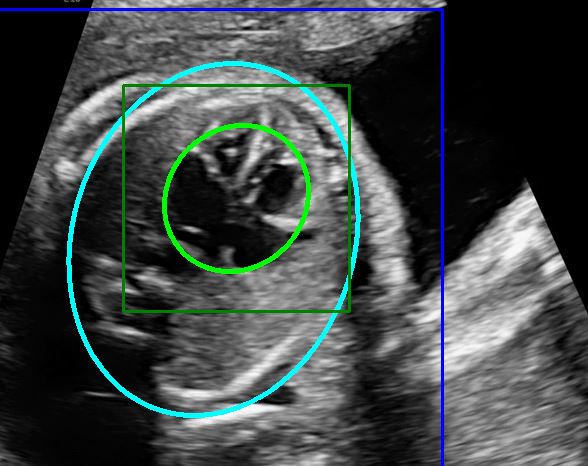

In [18]:
ind += 1



# Load Image
img_id = dataset.images[ind]
img_info = dataset.coco.loadImgs(ids=[img_id])[0]
img_path = os.path.join(dataset.img_dir, img_info['file_name'])
image = cv2.imread(img_path)
print(img_path)

# Load annotations
# ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
# anns = dataset.coco.loadAnns(ids=ann_ids)

# Inference
color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]
ret = detector.run(img_path)

for class_idx in range(opt.num_classes):
    class_id = class_idx + 1
    pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
    pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
    cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
    l = int(ret['results'][class_id][0, 6] / 4) # !attention here!
    ratio_al = ret['results'][class_id][0, 7]
    ratio_ba = ret['results'][class_id][0, 8]
    a = ratio_al * l
    b = ratio_ba * a
    theta = ret['results'][class_id][0, 9]
    angle = theta * 180
    print(pt1, pt2, (cx, cy), l, ratio_al, ratio_ba, theta, a, b, int(angle))
    
    pt1 = (int(cx - l / 2), int(cy - l / 2))
    pt2 = (int(cx + l / 2), int(cy + l / 2))
    img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
    img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)
    
img = Image.fromarray(image)
img
img.save(os.path.join('../exp/pred', img_path.split('/')[-1]))

In [146]:
len(dataset.images)

100

In [147]:
for ind in range(len(dataset.images)):

    # Load Image
    img_id = dataset.images[ind]
    img_info = dataset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(dataset.img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    print(img_path)

    # Load annotations
    # ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
    # anns = dataset.coco.loadAnns(ids=ann_ids)

    # Inference
    color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]
    red = (255, 0, 0)
    green = (0, 255, 0)
    ret = detector.run(img_path)

    for class_idx in range(opt.num_classes):
        class_id = class_idx + 1
        pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
        pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
        cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
        l = int(ret['results'][class_id][0, 6] / 4) # !attention here!
        ratio_al = ret['results'][class_id][0, 7]
        ratio_ba = ret['results'][class_id][0, 8]
        a = ratio_al * l
        b = ratio_ba * a
        theta = ret['results'][class_id][0, 9]
        angle = theta * 180
        print(pt1, pt2, (cx, cy), l, ratio_al, ratio_ba, theta, a, b, int(angle))

        pt1 = (int(cx - l / 2), int(cy - l / 2))
        pt2 = (int(cx + l / 2), int(cy + l / 2))
        img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
        img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)

    img = Image.fromarray(image)
    img.save(os.path.join('../exp/pred', img_path.split('/')[-1]))

/data/cc/Data/CHD/detection/images/abnormal_0000.png
(-936, -1078) (1752, 1610) (408, 265) 672 0.38649797 0.8034471 0.59329367 259.7266387939453 208.67662183324683 106
(-185, -443) (1156, 898) (485, 227) 335 0.37068468 0.845624 0.7307339 124.17936891317368 105.00905833806092 131


/home/cc/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/data/cc/Data/CHD/detection/images/abnormal_0001.png
(-1316, -1272) (1915, 1958) (299, 342) 807 0.38554302 0.7937233 0.63559026 311.1332159936428 246.95367833275895 114
(-571, -638) (1256, 1189) (342, 275) 456 0.33497074 0.92716104 0.7286147 152.7466585636139 141.62075049294316 131
/data/cc/Data/CHD/detection/images/abnormal_0002.png
(-685, -837) (1439, 1287) (377, 224) 531 0.37524202 0.83682317 0.6011875 199.25351509451866 166.73995722180283 108
(-284, -431) (938, 790) (327, 179) 305 0.35961708 0.8853992 0.6915283 109.68321070075035 97.11342946192383 124
/data/cc/Data/CHD/detection/images/abnormal_0003.png
(-692, -752) (1530, 1470) (418, 358) 555 0.39406824 0.78408897 0.555698 218.70787382125854 171.48643134713808 100
(2, -134) (973, 836) (487, 350) 242 0.40083143 0.7550271 0.67525923 97.00120633840561 73.23854100667164 121
/data/cc/Data/CHD/detection/images/abnormal_0004.png
(-519, -769) (1604, 1353) (542, 292) 530 0.39346087 0.7875335 0.55879354 208.53426098823547 164.2277209412086 

/data/cc/Data/CHD/detection/images/abnormal_0032.png
(-806, -967) (1589, 1427) (391, 230) 598 0.38490686 0.81165266 0.5962233 230.17430120706558 186.82158392349126 107
(-206, -404) (939, 741) (366, 168) 286 0.35623533 0.889675 0.6737016 101.8833030462265 90.64302979468103 121
/data/cc/Data/CHD/detection/images/abnormal_0033.png
(-909, -1115) (2023, 1817) (557, 350) 733 0.39270958 0.7791342 0.5783564 287.8561243712902 224.27855518535182 104
(-323, -462) (1273, 1134) (475, 335) 399 0.39549834 0.7689658 0.67642796 157.8038358092308 121.34574980602542 121
/data/cc/Data/CHD/detection/images/abnormal_0034.png
(-1166, -1531) (2495, 2130) (664, 299) 915 0.39691207 0.759723 0.5908772 363.174542337656 275.9120556172031 106
(-466, -761) (1548, 1253) (540, 246) 503 0.38555905 0.8128723 0.67110515 193.9362032711506 157.64536578547248 120
/data/cc/Data/CHD/detection/images/abnormal_0035.png
(-847, -983) (1615, 1480) (383, 248) 615 0.3936838 0.7713871 0.5814489 242.11553156375885 186.76479781112562 1

/data/cc/Data/CHD/detection/images/normal_0011.png
(-719, -946) (1796, 1569) (538, 311) 629 0.38840213 0.8016191 0.56186837 244.30494239926338 195.83951110341084 101
(-210, -377) (1151, 984) (470, 303) 340 0.4012519 0.76307815 0.67414427 136.4256501197815 104.10343313342523 121
/data/cc/Data/CHD/detection/images/normal_0012.png
(-1047, -1337) (2353, 2063) (653, 362) 850 0.3799395 0.82476175 0.58279085 322.9485720396042 266.35562889086265 104
(-284, -566) (1415, 1133) (565, 283) 424 0.35486376 0.8842327 0.67831975 150.46223545074463 133.04362868124753 122
/data/cc/Data/CHD/detection/images/normal_0013.png
(-1328, -1566) (2431, 2192) (551, 313) 939 0.38674694 0.7987437 0.6216092 363.15537947416306 290.0680804907023 111
(-521, -632) (1519, 1408) (498, 388) 510 0.38006058 0.8119076 0.67992705 193.83089751005173 157.37277675552056 122
/data/cc/Data/CHD/detection/images/normal_0014.png
(-656, -762) (1483, 1378) (413, 307) 535 0.3723557 0.8542538 0.5708149 199.21029925346375 170.1761608189905

/data/cc/Data/CHD/detection/images/normal_0041.png
(-848, -933) (1656, 1571) (404, 318) 626 0.38553208 0.80070436 0.5949264 241.34308278560638 193.24445864426457 107
(-246, -325) (957, 878) (355, 276) 300 0.38648233 0.8026103 0.67156076 115.94469845294952 93.05840667297183 120
/data/cc/Data/CHD/detection/images/normal_0042.png
(-868, -1035) (1905, 1738) (518, 351) 693 0.38248134 0.8247764 0.6210107 265.05956625938416 218.61487777561234 111
(-188, -292) (1073, 970) (442, 339) 315 0.3993388 0.7493425 0.67513514 125.79172566533089 94.2610863357297 121
/data/cc/Data/CHD/detection/images/normal_0043.png
(-548, -723) (1527, 1352) (489, 314) 519 0.3818812 0.83510983 0.56738937 198.1963465511799 165.5157172556823 102
(-193, -316) (1142, 1019) (474, 351) 334 0.38090873 0.84981287 0.58829707 127.22351503372192 108.11617983890773 105
/data/cc/Data/CHD/detection/images/normal_0044.png
(-990, -1014) (1564, 1540) (286, 262) 638 0.40253827 0.749724 0.6030265 256.8194161057472 192.54367244446362 108
(

In [145]:
img = Image.fromarray(image)
img.save(os.path.join('../exp/pred', img_path.split('/')[-1]))

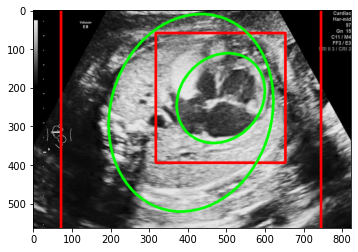

In [37]:
# image = np.array(Image.open(img_path).convert('RGB'))
lung_pt1 = (int(cx - l / 2), int(cy - l / 2))
lung_pt2 = (int(cx + l / 2), int(cy + l / 2))
img = cv2.rectangle(img=image, pt1=lung_pt1, pt2=lung_pt2, color=(255, 0, 0), thickness=5)
img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, (0, 255, 0), thickness=5)
# img = cv2.rectangle(img=img, pt1=heart_pt1, pt2=heart_pt2, color=(0, 0, 255), thickness=5)
    
plt.imshow(image)

In [14]:
preprocessed_image, meta = detector.pre_process(image, scale=1.0)
preprocessed_image = preprocessed_image.to(opt.device)
preprocessed_image.shape

torch.Size([1, 3, 512, 512])

In [15]:
output = model(preprocessed_image)[-1]

In [ ]:
print(output['hm'].shape, output['reg'].shape, output['l'].shape, output['ratio_al'].shape, output['ratio_ba'].shape, output['theta'].shape)

In [ ]:
from models.decode import _nms, _left_aggregate, _right_aggregate, _top_aggregate, \
                        _bottom_aggregate, _h_aggregate, _v_aggregate, _topk_channel, \
                        _topk
from models.utils import _gather_feat, _transpose_and_gather_feat

In [ ]:
def test_eldet_decode(heat, l, ratio_al, ratio_ba, theta, reg=None, cat_spec_wh=False, K=2): # Decode ellipse information
    batch, cat, height, width = heat.size()

    # heat = torch.sigmoid(heat)
    # perform nms on heatmaps
    heat = _nms(heat)
      
    scores, inds, clses, ys, xs = _topk(heat, K=K)
    if reg is not None:
      reg = _transpose_and_gather_feat(reg, inds)
      reg = reg.view(batch, K, 2)
      xs = xs.view(batch, K, 1) + reg[:, :, 0:1]
      ys = ys.view(batch, K, 1) + reg[:, :, 1:2]
    else:
      xs = xs.view(batch, K, 1) + 0.5
      ys = ys.view(batch, K, 1) + 0.5
    l = _transpose_and_gather_feat(l, inds)
    ratio_al = _transpose_and_gather_feat(ratio_al, inds)
    ratio_ba = _transpose_and_gather_feat(ratio_ba, inds)
    theta = _transpose_and_gather_feat(theta, inds)
    if cat_spec_wh:
      l = l.view(batch, K, cat, 1)
      clses_ind = clses.view(batch, K, 1, 1).expand(batch, K, 1, 2).long()
      l = l.gather(1, clses_ind).view(batch, K, 1)
    else:
      l = l.view(batch, K, 1)
    clses  = clses.view(batch, K, 1).float()
    scores = scores.view(batch, K, 1)
    bboxes = torch.cat([xs - l / 2, 
                        ys - l / 2,
                        xs + l / 2, 
                        ys + l / 2], dim=2)
#     print(bboxes.shape, scores.shape, clses.shape, xs.shape, ys.shape, l.shape, ratio_al.shape, ratio_ba.shape, theta.shape)
#     print('bboxes:', bboxes, 'scores:', scores, 'clses:', clses, 'xs:', xs, 'ys:', ys, 'l:', l, 'ratio_al:', ratio_al, 'ratio_ba:', ratio_ba, 'theta:', theta)
    detections = torch.cat([bboxes, scores, clses, xs, ys, l, ratio_al, ratio_ba, theta], dim=2) # batch x max_dets x dim
      
    return detections

In [ ]:
def transform_preds(coords, center, scale, output_size):
    target_coords = np.zeros(coords.shape)
    trans = get_affine_transform(center, scale, 0, output_size, inv=1)
    for p in range(coords.shape[0]):
        target_coords[p, 0:2] = affine_transform(coords[p, 0:2], trans)
    return target_coords

def affine_transform(pt, t):
    new_pt = np.array([pt[0], pt[1], 1.], dtype=np.float32).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2]

def get_affine_transform(center,
                         scale,
                         rot,
                         output_size,
                         shift=np.array([0, 0], dtype=np.float32),
                         inv=0):
    if not isinstance(scale, np.ndarray) and not isinstance(scale, list):
        scale = np.array([scale, scale], dtype=np.float32)

    scale_tmp = scale
    src_w = scale_tmp[0]
    dst_w = output_size[0]
    dst_h = output_size[1]

    rot_rad = np.pi * rot / 180
    src_dir = get_dir([0, src_w * -0.5], rot_rad)
    dst_dir = np.array([0, dst_w * -0.5], np.float32)

    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)
    src[0, :] = center + scale_tmp * shift
    src[1, :] = center + src_dir + scale_tmp * shift
    dst[0, :] = [dst_w * 0.5, dst_h * 0.5]
    dst[1, :] = np.array([dst_w * 0.5, dst_h * 0.5], np.float32) + dst_dir

    src[2:, :] = get_3rd_point(src[0, :], src[1, :])
    dst[2:, :] = get_3rd_point(dst[0, :], dst[1, :])

    if inv:
        trans = cv2.getAffineTransform(np.float32(dst), np.float32(src))
    else:
        trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))

    return trans

def get_dir(src_point, rot_rad):
    sn, cs = np.sin(rot_rad), np.cos(rot_rad)

    src_result = [0, 0]
    src_result[0] = src_point[0] * cs - src_point[1] * sn
    src_result[1] = src_point[0] * sn + src_point[1] * cs

    return src_result

def get_3rd_point(a, b):
    direct = a - b
    return b + np.array([-direct[1], direct[0]], dtype=np.float32)


In [ ]:
# output -> detection
hm = output['hm'].sigmoid_()
l = output['l']
ratio_al = output["ratio_al"]
ratio_ba = output["ratio_ba"]
theta = output["theta"]
reg = output['reg'] if opt.reg_offset else None

dets = test_eldet_decode(hm, l, ratio_al, ratio_ba, theta, reg=reg)
dets

In [ ]:
[meta['c']], [meta['s']], meta['out_height'], meta['out_width'], opt.num_classes

In [ ]:
ret = []
i = 0
num_classes = 2
top_preds = {}
c, s, h, w, num_classes = [meta['c']], [meta['s']], meta['out_height'], meta['out_width'], opt.num_classes

print("Origin:", dets)
dets[i, :, :2] = transform_preds(
      dets[i, :, 0:2], c[i], s[i], (w, h))
dets[i, :, 2:4] = transform_preds(
      dets[i, :, 2:4], c[i], s[i], (w, h))
print("Transformed:", dets)
classes = dets[i, :, -1]
for j in range(num_classes):
  inds = (classes == j)
  top_preds[j + 1] = np.concatenate([
    dets[i, inds, :4].astype(np.float32),
    dets[i, inds, 4:5].astype(np.float32)], axis=1).tolist()
ret.append(top_preds)

In [ ]:
classes

In [ ]:
# eldet post processing
def eldet_post_process(dets, c, s, h, w, num_classes):
  # dets: batch x max_dets x dim
  # return 1-based class det dict
  ret = []
  for i in range(dets.shape[0]):
    top_preds = {}
    dets[i, :, :2] = transform_preds(
          dets[i, :, 0:2], c[i], s[i], (w, h))
    dets[i, :, 2:4] = transform_preds(
          dets[i, :, 2:4], c[i], s[i], (w, h))
    classes = dets[i, :, -1]
    for j in range(num_classes):
      inds = (classes == j)
      top_preds[j + 1] = np.concatenate([
        dets[i, inds, :4].astype(np.float32),
        dets[i, inds, 4:5].astype(np.float32)], axis=1).tolist()
    ret.append(top_preds)
  return ret

In [ ]:
dets = dets.detach().cpu().numpy()
dets = dets.reshape(1, -1, dets.shape[2])
dets = eldet_post_process(
    dets.copy(), [meta['c']], [meta['s']],
    meta['out_height'], meta['out_width'], self.opt.num_classes)
for j in range(1, self.num_classes + 1):
  dets[0][j] = np.array(dets[0][j], dtype=np.float32).reshape(-1, 5)
  dets[0][j][:, :4] /= scale

In [ ]:
def post_process(self, dets, meta, scale=1):
    dets = dets.detach().cpu().numpy()
    dets = dets.reshape(1, -1, dets.shape[2])
    dets = eldet_post_process(
        dets.copy(), [meta['c']], [meta['s']],
        meta['out_height'], meta['out_width'], self.opt.num_classes)
    for j in range(1, self.num_classes + 1):
      dets[0][j] = np.array(dets[0][j], dtype=np.float32).reshape(-1, 5)
      dets[0][j][:, :4] /= scale
    return dets[0]

In [ ]:
batch, cat, height, width = hm.size()
heat = _nms(hm)
scores, inds, clses, ys, xs = _topk(heat, K=2)
scores, inds, clses, ys, xs

In [ ]:
reg.shape, inds

In [ ]:
K = 2
cat_spec_wh = False
if reg is not None:
  reg = _transpose_and_gather_feat(reg, inds)
  reg = reg.view(batch, K, 2)
  xs = xs.view(batch, K, 1) + reg[:, :, 0:1]
  ys = ys.view(batch, K, 1) + reg[:, :, 1:2]
else:
  xs = xs.view(batch, K, 1) + 0.5
  ys = ys.view(batch, K, 1) + 0.5
l = _transpose_and_gather_feat(l, inds)
if cat_spec_wh:
  l = l.view(batch, K, cat, 1)
  clses_ind = clses.view(batch, K, 1, 1).expand(batch, K, 1, 2).long()
  l = l.gather(1, clses_ind).view(batch, K, 1)
else:
  l = l.view(batch, K, 1)
clses  = clses.view(batch, K, 1).float()
scores = scores.view(batch, K, 1)

In [ ]:
results = {}
num_iters = len(dataset)
bar = Bar('{}'.format(opt.exp_id), max=num_iters)
time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge']
avg_time_stats = {t: AverageMeter() for t in time_stats}
for ind in range(num_iters):
    img_id = dataset.images[ind]
    img_info = dataset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(dataset.img_dir, img_info['file_name'])

    if opt.task == 'ddd':
        ret = detector.run(img_path, img_info['calib'])
    else:
        ret = detector.run(img_path)

    results[img_id] = ret['results']

    Bar.suffix = '[{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(ind, num_iters, total=bar.elapsed_td, eta=bar.eta_td)
    for t in avg_time_stats:
        avg_time_stats[t].update(ret[t])
        Bar.suffix = Bar.suffix + '|{} {:.3f} '.format(t, avg_time_stats[t].avg)
    bar.next()
bar.finish()
dataset.run_eval(results, opt.save_dir)

In [ ]:
results

In [ ]:
print(img_id)
img_info = dataset.coco.loadImgs(ids=[img_id])[0]

# Inference

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
test_image_folder = '/data/cc/Data/CHD/detection/images/'
image_lists = sorted(glob(os.path.join(test_image_folder, "*.png")))
save_folder = '/data/cc/Data/CHD/detection/predictions/'

In [ ]:
idx = 0
for img_path in image_lists:
    
    idx += 1
    
    img_name = img_path.split('/')[-1]
    ret = detector.run(img_path)
    
    lung_pt1 = (int(ret['results'][1][0][0]), int(ret['results'][1][0][1]))
    lung_pt2 = (int(ret['results'][1][0][2]), int(ret['results'][1][0][3]))
    heart_pt1 = (int(ret['results'][2][0][0]), int(ret['results'][2][0][1]))
    heart_pt2 = (int(ret['results'][2][0][2]), int(ret['results'][2][0][3]))
    
    image = np.array(Image.open(img_path).convert('RGB'))
    img = cv2.rectangle(img=image, pt1=lung_pt1, pt2=lung_pt2, color=(255, 0, 0), thickness=5)
    img = cv2.rectangle(img=img, pt1=heart_pt1, pt2=heart_pt2, color=(0, 0, 255), thickness=5)
    
    result = Image.fromarray(img)
    result.save(os.path.join(save_folder, img_name))
    
    print("Processing img: {}, shape:{}, Lung pt1:{} pt2:{}, Heart pt1:{}, pt2:{}".format(img_name, image.shape, lung_pt1, lung_pt2, heart_pt1, heart_pt2))
    
#     if idx > 1:
#         break


In [ ]:
ret

In [ ]:
lung_pt1 = (int(ret['results'][1][0][0]), int(ret['results'][1][0][1]))
lung_pt2 = (int(ret['results'][1][0][2]), int(ret['results'][1][0][3]))
heart_pt1 = (int(ret['results'][2][0][0]), int(ret['results'][2][0][1]))
heart_pt2 = (int(ret['results'][2][0][2]), int(ret['results'][2][0][3]))

In [ ]:
img = np.array(Image.open(img_path).convert('RGB'))
plt.imshow(img)

In [ ]:
img_path

In [ ]:
l = img[:]
l = cv2.rectangle(img=l, pt1=lung_pt1, pt2=lung_pt2, color=(255, 0, 0), thickness=5)
l = cv2.rectangle(img=l, pt1=heart_pt1, pt2=heart_pt2, color=(0, 0, 255), thickness=5)
plt.imshow(l)

In [ ]:
result = Image.fromarray(l)
result.save(os.path.join(save_folder, img_name))

# Rotated IoU

In [18]:
import math
from torch import nn, optim
import argparse
from utiles import box2corners
from oriented_iou_loss import cal_diou, cal_giou

In [16]:
output

{'hm': tensor([[[[-4.3433, -5.5296, -5.5170,  ..., -5.3087, -5.2807, -4.2913],
           [-5.4693, -7.2061, -7.2195,  ..., -6.9011, -6.8778, -5.3490],
           [-5.4691, -7.1824, -7.1806,  ..., -6.9330, -6.8808, -5.4019],
           ...,
           [-5.2143, -6.8130, -6.8661,  ..., -7.1894, -7.0903, -5.5019],
           [-5.3262, -6.8891, -6.8383,  ..., -7.1273, -7.0633, -5.4696],
           [-4.3603, -5.3907, -5.3109,  ..., -5.4597, -5.4542, -4.3752]],
 
          [[-4.4292, -5.5015, -5.5068,  ..., -5.3757, -5.3183, -4.2863],
           [-5.4769, -7.0954, -7.1240,  ..., -6.9488, -6.8777, -5.3009],
           [-5.4566, -7.0729, -7.0850,  ..., -6.9706, -6.9265, -5.3418],
           ...,
           [-5.1941, -6.6772, -6.7317,  ..., -7.1623, -7.0690, -5.4433],
           [-5.2653, -6.7094, -6.6905,  ..., -7.0680, -7.0011, -5.3971],
           [-4.2260, -5.1407, -5.1102,  ..., -5.3456, -5.3033, -4.3035]]]],
        device='cuda:0', grad_fn=<AddBackward0>),
 'reg': tensor([[[[0.5947, 0.8

In [42]:
bbox1 = torch.tensor([[[125, 125, 100, 50, math.pi]]]).cuda()
bbox2 = torch.tensor([[[125, 125, 100, 50, 0.0 * math.pi]]]).cuda()
print(bbox1.shape, bbox2.shape)
print(bbox1, bbox2)
iou_loss, iou = cal_diou(bbox1, bbox2)
iou_loss, iou

torch.Size([1, 1, 5]) torch.Size([1, 1, 5])
tensor([[[125.0000, 125.0000, 100.0000,  50.0000,   3.1416]]], device='cuda:0') tensor([[[125., 125., 100.,  50.,   0.]]], device='cuda:0')


(tensor([[0.]], device='cuda:0'), tensor([[1.]], device='cuda:0'))

In [252]:
# Using ratio_bl

angle_errors = []
dices = []
ious = []
bbox_ious = []


for ind in range(len(dataset)):
    ind = 34
    # Load Image
    
    cls_dice = []
    cls_angle_error = []
    cls_iou = []
    cls_bbox_iou = []
    
    img_id = dataset.images[ind]
    img_info = dataset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(dataset.img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    shape = image.shape[:2]

    # Load annotations
    ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
    anns = dataset.coco.loadAnns(ids=ann_ids)

    # Inference
    color_maps = [(0, 0, 255), (0, 255, 255), (0, 128, 0), (0, 255, 0)]
    ret = detector.run(img_path)

    for class_idx in range(opt.num_classes):
        try:
            class_id = class_idx + 1
            pt1 = (int(ret['results'][class_id][0, 0]), int(ret['results'][class_id][0, 1]))
            pt2 = (int(ret['results'][class_id][0, 2]), int(ret['results'][class_id][0, 3]))
            cx, cy = int(ret['results'][class_id][0, 4]), int(ret['results'][class_id][0, 5])
            l = int(ret['results'][class_id][0, 6]) # !attention here!
            ratio_al = ret['results'][class_id][0, 7]
            ratio_bl = ret['results'][class_id][0, 8]
            a = ratio_al * l / 2
            b = ratio_bl * l / 2
            theta = ret['results'][class_id][0, 9]
            angle = theta * 180
            print("Predict:     ", pt1, pt2, (cx, cy), l, ratio_al, ratio_bl, "({})'".format(theta), int(a), int(b), int(angle))

            # Annotations
            ann = anns[class_idx]
            cx_gt, cy_gt, a_gt, b_gt, theta_gt = ann['ellipse']
            theta_gt = theta_gt / math.pi
            theta_gt = theta_gt - 1 if theta_gt > 0.5 else theta_gt + 1 if theta_gt < -0.5 else theta_gt
            l_gt = 2 * math.sqrt(a_gt ** 2 + b_gt ** 2)
            pt1 = (int(cx_gt - l_gt / 2), int(cy_gt - l_gt / 2))
            pt2 = (int(cx_gt + l_gt / 2), int(cy_gt + l_gt / 2))
            ratio_al, ratio_bl = 2 * a_gt / l_gt, 2 * b_gt / l_gt
            angle_gt = theta_gt * 180
            print("Ground Truth:", pt1, pt2, (cx_gt, cy_gt), l_gt, ratio_al, ratio_bl, "({})'".format(theta_gt), int(a_gt), int(b_gt), int(angle_gt))
#             img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=(125, 0, 0), thickness=1)
            img = cv2.ellipse(image, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, color=color_maps[class_idx * 2 + 1], thickness=2)
        #     img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2 + 1], thickness=2)
        #     img = cv2.ellipse(image, (cx_gt, cy_gt), (int(a_gt), int(b_gt)), angle_gt, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=2)


            pt1 = (int(cx - l / 2), int(cy - l / 2))
            pt2 = (int(cx + l / 2), int(cy + l / 2))
#             img = cv2.rectangle(img=image, pt1=pt1, pt2=pt2, color=color_maps[class_idx * 2], thickness=2)
#             img = cv2.ellipse(img, (cx, cy), (int(a), int(b)), angle, 0.0, 360.0, color_maps[class_idx * 2 + 1], thickness=3)

            pred_ell = [cx, cy, a, b, angle]
            gt_ell = [cx_gt, cy_gt, a_gt, b_gt, angle_gt]
            error = compute_single_class_metric(pred_ell, gt_ell, shape)
            print("dice: {}  iou:{}  bbox_iou: {}  angle_error: {}".format(error[0], error[1], error[2], error[3]))
            cls_dice.append(error[0])
            cls_iou.append(error[1])
            cls_bbox_iou.append(error[2])
            cls_angle_error.append(error[3])
            
        except Exception as e:
            print(e)
            cls_dice.append(0)
            cls_iou.append(0)
            cls_bbox_iou.append(0)
            cls_angle_error.append(90)
            pass
    img = Image.fromarray(img)
    img.save('label.png')
#     print("Saving", img_path, "to", os.path.join(save_pred_folder, img_path.split('/')[-1]))
#     img.save(os.path.join(save_pred_folder, img_path.split('/')[-1]))
#     print("Saving", img_path, "to", os.path.join(save_pred_folder, img_path.split('/')[-1]))
    dices.append(cls_dice)
    ious.append(cls_iou)
    bbox_ious.append(cls_bbox_iou)
    angle_errors.append(cls_angle_error)
#     img
    break


Predict:      (-37, -44) (794, 788) (378, 372) 832 0.49633774 0.36814708 (0.0029389741830527782)' 206 153 0
Ground Truth: (8, -46) (821, 766) (415, 360) 813.2595489854392 0.7924850077739932 0.6098913939821203 (0.08804217608343967)' 322 248 15
dice: 0.5669879778891793  iou:0.39566170355919866  bbox_iou: 0.3956793546676636  angle_error: 15.31857634206964
Predict:      (196, 35) (811, 651) (504, 343) 615 1.0 0.98237014 (0.0009649893036112189)' 307 302 0
Ground Truth: (279, 119) (726, 566) (503, 343) 446.29608288668635 0.8290460395861065 0.5591803503759695 (-0.15087888605111677)' 185 124 -27
dice: 0.39796982738597514  iou:0.2484159375953636  bbox_iou: 0.24851427972316742  angle_error: 27.331897563851037
